<h2><center><font color=#D40004><u>Benchmark 2: Openchat-3.5-1210 and dolphin-2.2.1-mistral-7b </u></font></center></h2>


<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
        Notebook Gool
    </h2>
    <p style="font-size: 140%; color: #34495e; letter-spacing: 1px;">T
The objective of this notebook is to evaluate the performance of Openchat-3.5-1210 and dolphin-2.2.1-mistral-7b using the Table-extract Benchmark dataset available at <a href="https://huggingface.co/datasets/Effyis/Table-Extraction" style="color: #fffff; text-decoration: none;">Hugging Face.</a></p>
</div>


# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:center; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'></span></b> <b>Table of Content</b></div>

* [I. Loading and Importing Libraries](#1)
* [II. Definition and Implementation of Metrics](#2)
* [III. Clean Response Obtained by LLM](#3)
* [IV. Prepare Data for Benchmarking](#5)
* [V. Benchmark](#6)
  * [Openchat-3.5-1210](#7)
  * [dolphin-2.2.1-mistral-7b](#8)
  

<a id='1'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>I |</span></b> <b>Loading and Importing Libraries</b></div>


In [1]:
%%capture
!pip install --upgrade pip
!pip install bitsandbytes
!pip install transformers

In [2]:
import re
import json
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset, Dataset
from wand.image import Image as WImage
import torch
import time 
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

<a id='2'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>II |</span></b> <b>Definition and Implementation of Metrics</b></div>
So, let's begin by providing an example of the expected output.

In [3]:
desired_output = {
    "GeographicContext": "Intercountry",
    "SubGeographicContext": "Intra-Western",
    "Channel": "purchase at ATM",
    "RateType": "fallback fee rates",
    "Notes":["Maestro MO/TO is permitted only for refund transactions.",
"For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Maestro acceptance criteria."],
    
    "Rates": [
        {
            "PaymentProduct": "Maestro Prepaid Commercial",
            "Details": [
                {
                    "FeeTier": "Chip",
                    "IRD": ["45"],
                    "Rate": "0.40% + EUR 0.05"
                },
                {
                    "FeeTier": "Chip: Late Presentment",
                    "IRD": ["45"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "PIN Verified",
                    "IRD": ["46"],
                    "Rate": "0.50% + EUR 0.05"
                },
                {
                    "FeeTier": "Signature Verified",
                    "IRD": ["47"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "Masterpass Wallet",
                    "IRD": ["PW"],
                    "Rate": "1.50%"
                },
                {
                    "FeeTier": "Secure E-commerce",
                    "IRD": ["48"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Mail Order/Telephone Order",
                    "IRD": ["MO"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Contactless",
                    "IRD": ["P1"],
                    "Rate": "0.40% + EUR 0.05"
                }
            ]
        },
        {
            "PaymentProduct": "Maestro",
            "Details": [
                {
                    "FeeTier": "Purchase part of the Purchase with Cash Back transaction",
                    "IRD": [],
                    "Rate": "Depending on tier claimed POS interchange rate relevant to the applicable tier. Refer to Intra-EEA Maestro POS Fallback Interchange Fee Rates."
                },
                {
                    "FeeTier": "Cash back part of the Purchase with Cash Back transaction",
                    "IRD": ["N/A"],
                    "Rate": "0.00"
                }
            ]
        }
    ]
}


To compare between the expected JSON and the predicted JSON, we first need to verify the percentage of predicted keys relative to the desired keys

>##  Percentage of predicted keys

Let's begin by defining a function to retrieve all keys from a dictionary.

In [4]:
def get_keys(d):
    # Iterate over each key-value pair in the dictionary
    for k, v in d.items():
        # Append the key to the list of all_keys
        all_keys.append(k)
        # If the value is a dictionary, recursively call get_keys
        if isinstance(v, dict):
            get_keys(v)
        # If the value is a list, iterate over each item
        elif isinstance(v, list):
            for item in v:
                # If the item is a dictionary, recursively call get_keys
                if isinstance(item, dict):
                    get_keys(item)
# Define a function to retrieve all unique keys from a nested dictionary
def get_all_keys(d):
    # Declare all_keys as a global variable
    global all_keys
    # Initialize all_keys as an empty list
    all_keys = []
    # Call the helper function get_keys to populate all_keys
    get_keys(d)
    # Return a list containing the unique keys by converting all_keys to a set and then back to a list
    return list(set(all_keys))

In [5]:
# Testing our function
get_all_keys(desired_output)

['SubGeographicContext',
 'FeeTier',
 'Channel',
 'RateType',
 'Notes',
 'Details',
 'Rate',
 'Rates',
 'PaymentProduct',
 'GeographicContext',
 'IRD']

Now, we define the percentage of predicted keys as follows:

$$\Large \text{Percentage of predicted keys} = \frac{\text{Number of correctly predicted keys}}{\text{Total number of true keys}}$$


In [6]:
def Percentage_of_predicted_keys(true_dic, pred_dic):
    # Get all keys of the true dictionary
    all_keys_of_true_dic = get_all_keys(true_dic)
    # Get all keys of the predicted dictionary
    all_keys_of_pred_dic = get_all_keys(pred_dic)
    
    # Check if there are no keys in the true dictionary to avoid division by zero
    if len(all_keys_of_true_dic) == 0:
        return 0  # Avoid division by zero
    
    # Initialize count of predicted keys
    p_keys = 0
    # Iterate through all keys in the predicted dictionary
    for key in all_keys_of_pred_dic:
        # Check if the key is also present in the true dictionary
        if key in all_keys_of_true_dic:
            # Increment count if the key is found in both dictionaries
            p_keys += 1
    
    # Calculate the percentage of predicted keys compared to true keys
    p_keys /= len(all_keys_of_true_dic)
    # Return the percentage of predicted keys
    return p_keys

In [7]:
# Define a true dictionary
true_dict = {
    "name": "John",
    "age": 30,
    "city": "New York"
}

# Define a predicted dictionary with some correct and some incorrect keys
pred_dict = {
    "name": "John",
    "age": 30,
    "country": "USA"
}

# Calculate the percentage of predicted keys
percentage = Percentage_of_predicted_keys(true_dict, pred_dict)

# Print the result
print("Percentage of predicted keys:", percentage)

Percentage of predicted keys: 0.6666666666666666


Now we will define the principal metrics used to compare the values of two JSON objects.

>## Percentage of predicted values

The function calculates the percentage of correctly predicted values compared to the total number of true values across different types of data structures.

The formula for calculating the percentage of values is as follows:

$$
\text{Percentage of values} = \frac{\sum_{i=1}^{\text{Total number of predicted keys}} p_i \cdot w_i}{\sum_{i=1}^{\text{Total number of true keys}} w_i}
$$

Here, $p_i$ represents the percentage of correctly predicted values for each key. It's calculated as:

$$p_i = \frac{\text{Number of correctly predicted values of item i}}{\text{Total number of true values of item i}}$$

and $ w_i$ is the total number of true values of item i.

In [8]:
# Define a function to count the values in a nested dictionary. This function assists in calculating weights.
def count_values_in_dic(d):
    # Initialize a counter
    count = 0
    
    # Check if d is a string
    if isinstance(d, (str,int,float)):
        # Increment the counter
        count += 1
        
    # Check if d is a list containing only strings
    if isinstance(d, list) and all(isinstance(item, (str,int,float)) for item in d):
        # Add the length of the list to the counter
        count += len(d)
        
    # Check if d is a list containing only dictionaries
    if isinstance(d, list) and all(isinstance(item, dict) for item in d):
        # Iterate through each item in the list
        for item in d:
            # Recursively call count_values_in_dic for each item in the list
            count += count_values_in_dic(item)
  
    # Check if d is a dictionary
    if isinstance(d, dict):
        # Traverse through the dictionary items
        for key, value in d.items():
            # If the value is a string, increment the counter
            if isinstance(value, (str,int,float)):
                count += 1
            
            # If the value is a dictionary, count its values recursively
            elif isinstance(value, dict):
                count += count_values_in_dic(value)
                    
            # If the value is a list, count the values in the list      
            elif isinstance(value, list):
                # Iterate through each element in the list
                for item in value:
                    # If the element is a dictionary, count its values
                    if isinstance(item, dict):
                        count += count_values_in_dic(item)
                    # If the element is a string, increment the counter
                    elif isinstance(item, (str,int,float)):
                        count += 1

    # Return the total count
    return count

In [9]:
# Define a sample nested dictionary
sample_dict = {
    "name": "John",
    "age": 30,
    "city": "New York",
    "friends": [
        {
            "name": "Alice",
            "age": 28
        },
        {
            "name": "Bob",
            "age": 32
        }
    ],
    "hobbies": ["reading", "traveling", "cooking"]
}

# Count the values in the dictionary
values_count = count_values_in_dic(sample_dict)

# Print the result
print("Number of values in the dictionary:", values_count)

Number of values in the dictionary: 10


In [35]:
def calculate_percentage_of_values(true_dic, pred_dic):
    total_percentage = 0  # Initialize total percentage
    sum_of_w_i = 0 # Initialize sum of weights
    
    # Type 1: Single string values
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, str):  # Check if the value is a string
            w_i = 1 # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            # Check if the key exists in pred_dic, if its value is a string and if it matches the true value
            if key in pred_dic and isinstance(pred_dic[key], str) and pred_dic[key] == true_value:
                match = 1  # Assign perfect match
            else:
                match = 0  # Assign no match
            total_percentage += match*w_i  # Add the match value to the total percentage
            
    # Type 2: Lists of strings
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, str) for item in true_value):
            # Check if the value is a list of strings
            w_i = len(true_value) # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            total_number_of_true_values = len(true_value)  # Get the total number of true values
            
            if key in pred_dic and isinstance(pred_dic[key], list):
                # Check if the key exists in pred_dic and its value is a list
                correct_pred_values = sum(1 for v in pred_dic[key] if v in true_value)  # Count correct predictions
            else:
                correct_pred_values = 0  # No correct predictions if the key doesn't exist or its value is not a list
            if total_number_of_true_values:
                percentage_correct = correct_pred_values / total_number_of_true_values  # Calculate percentage of correct predictions
            else:
                percentage_correct = 0  # If there are no true values, assign 0
            total_percentage += percentage_correct*w_i  # Add the percentage to the total percentage
    
    # Type 4: dictionarie
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, dict)  :
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            
            if key in pred_dic and isinstance(pred_dic[key], dict):
                percentage_correct = calculate_percentage_of_values(true_value, pred_dic[key])
            else:
                percentage_correct = 0
            total_percentage += percentage_correct*w_i
    # Type 5: Lists of dictionaries
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, dict) for item in true_value):
            # Check if the value is a list of dictionaries
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            sub_total_percentage = 0  # Initialize subtotal percentage
            
            for dict_item in true_value:  # Loop through each dictionary in the list
                max_similarity = 0  # Initialize max similarity score
                most_similar_pred_item = None  # Initialize most similar predicted item
                pred_items = pred_dic.get(key, [])  # Get predicted items for the current key
                #print(dict_item)
                for pred_item in pred_items:  # Loop through each prediction for the current key
                    
                    similarity = calculate_percentage_of_values(dict_item, pred_item)  # Calculate similarity

                    if similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_pred_item = pred_item
                    if max_similarity==1:
                        break
                if most_similar_pred_item is not None:
                    pred_items.remove(most_similar_pred_item)  # Remove the most similar predicted item from the list
                sub_total_percentage += max_similarity  # Add max similarity to subtotal
                
            if len(true_value) > 0:
                average_similarity = sub_total_percentage / len(true_value)  # Calculate average similarity
            else:
                average_similarity = 0  # If there are no dictionaries, assign 0
            total_percentage += average_similarity* w_i  # Add the percentage to the total percentage
    #print(total_percentage , sum_of_w_i)
    if sum_of_w_i==0:
        sum_of_w_i=1
    return total_percentage / sum_of_w_i  # Calculate and return the average percentage

In [11]:
true_dict = {
    'a': 'hello',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

pred_dict = {
    'a': 'Hey',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

# Calculate the percentage of predicted values
percentage = calculate_percentage_of_values(true_dict, pred_dict)

# Print the result
print("Percentage of predicted values:", percentage)

Percentage of predicted values: 0.9166666666666666


<a id='3'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>III |</span></b> <b>Clean Response Obtained by LLM</b></div>

Our goal is to obtain a response from LLM in JSON format. However, LLMs sometimes provide additional explanatory sentences along with the JSON data. Therefore, we need to define a function to extract only the JSON data from the response.

Here example of our issue:
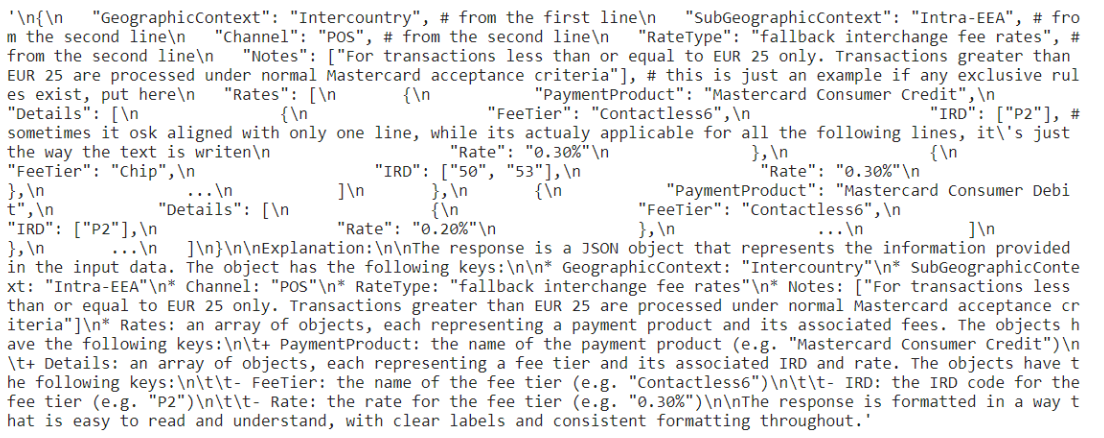

In [12]:
def clean_and_load_json(s):
    # Remove comments
    s = re.sub(r'//.*?\n', '', s)
    s = re.sub(r'#.*?\n', '', s) 
    # Remove trailing commas before closing brackets in lists and dictionaries
    s = re.sub(r',\s*\n\s*(\]|\})', r'\1', s)
    # Remove patterns like '\n       ...\n'
    s = re.sub(r'\n\s*\.\.\.\n', '', s)
    # Remove comma before } or ]
    s = re.sub(r',\s*(\]|\})', r'\1', s)
    # Remove unnecessary whitespace
    s = s.strip()
    # Load the cleaned JSON string
    print(s)
    return json.loads(s)

In [13]:
def parse_json(s):
    s = s.replace('{"message": "Context lacks a Payment product,FeeTier and Rate"}','')
    if '{' in s:    
        try:
            json_str = json.loads(s)
        except:
            # Find the index of the first occurrence of '{\n'
            start_idx = s.find('{')

            # Find the index of the last occurrence of '\n}'
            end_idx = s.rfind('}')

            # If either index is not found, raise an error
            if start_idx == -1 or end_idx == -1:
                return {"message": "Context lacks a Payment product,FeeTier and Rate"}

            # Extract the JSON substring from start_idx to end_idx (inclusive) + 3 to include the closing '\n}'
            json_str = s[start_idx:end_idx+1]
            try:
                 json_str = json.loads(json_str)
            except:
                json_str =  clean_and_load_json(json_str)
    else:
        return {"message": "Context lacks a Payment product,FeeTier and Rate"}
    return json_str

<a id='5'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>IV |</span></b> <b>Data Preparation</b></div>


In [14]:
df = pd.read_csv("/kaggle/input/table-extraction/table_extract.csv")
df.head()

context  \
0                    aircraft                    ...   
1    order year manufacturer                  mod...   
2                player       no    nationality  ...   
3               player  no              nationali...   
4                player       no    nationality  ...   

                                              answer  
0  {"aircraft":{"0":"robinson r - 22","1":"bell 2...  
1  {"order year":{"0":"1992 - 93","1":"1996","2":...  
2  {"player":{"0":"quincy acy","1":"hassan adams"...  
3  {"player":{"0":"patrick o'bryant","1":"jermain...  
4  {"player":{"0":"mark baker","1":"marcus banks"...

In [15]:
df = df.loc[:50]

<a id='6'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>V |</span></b> <b>Benchmark</b></div>


In [16]:
prompt = """Your task is to extract relevant information from the provided context and format it into a JSON object, following the template below.
 A JSON object representing the extracted table structure. The JSON object follows this format: 
 { "column_1": { "row_id": "val1", "row_id": "val2", ... }, 
 "column_2": { "row_id": "val1", "row_id": "val2", ... },
 ... } 
 Each key in the JSON object represents a column header, and the corresponding value is another object containing key-value pairs for each row in that column.

INPUT example:
# do not use the data from the examples & template; they are just for reference only. The following data contains actual information. If a value is not found, leave it empty. 

                  aircraft                    description      max gross weight                total disk area                        max disk loading
0          robinson r - 22       light utility helicopter      1370 lb (635 kg)  497 ft square (46.2 m square)   2.6 lb / ft square (14 kg / m square)
1     bell 206b3 jetranger  turboshaft utility helicopter     3200 lb (1451 kg)  872 ft square (81.1 m square)   3.7 lb / ft square (18 kg / m square)
2         ch - 47d chinook        tandem rotor helicopter   50000 lb (22680 kg)  5655 ft square (526 m square)   8.8 lb / ft square (43 kg / m square)
3              mil mi - 26        heavy - lift helicopter  123500 lb (56000 kg)  8495 ft square (789 m square)  14.5 lb / ft square (71 kg / m square)
4  ch - 53e super stallion        heavy - lift helicopter   73500 lb (33300 kg)  4900 ft square (460 m square)    15 lb / ft square (72 kg / m square)

OUTPUT example:
# do not use the data from the examples & template; they are just for reference only. The following data contains actual information. If a value is not found, leave it empty. 
{
  "aircraft": {
    "0": "robinson r - 22",
    "1": "bell 206b3 jetranger",
    "2": "ch - 47d chinook",
    "3": "mil mi - 26",
    "4": "ch - 53e super stallion"
  },
  "description": {
    "0": "light utility helicopter",
    "1": "turboshaft utility helicopter",
    "2": "tandem rotor helicopter",
    "3": "heavy - lift helicopter",
    "4": "heavy - lift helicopter"
  },
  "max gross weight": {
    "0": "1370 lb (635 kg)",
    "1": "3200 lb (1451 kg)",
    "2": "50000 lb (22680 kg)",
    "3": "123500 lb (56000 kg)",
    "4": "73500 lb (33300 kg)"
  },
  "total disk area": {
    "0": "497 ft square (46.2 m square)",
    "1": "872 ft square (81.1 m square)",
    "2": "5655 ft square (526 m square)",
    "3": "8495 ft square (789 m square)",
    "4": "4900 ft square (460 m square)"
  },
  "max disk loading": {
    "0": "2.6 lb / ft square (14 kg / m square)",
    "1": "3.7 lb / ft square (18 kg / m square)",
    "2": "8.8 lb / ft square (43 kg / m square)",
    "3": "14.5 lb / ft square (71 kg / m square)",
    "4": "15 lb / ft square (72 kg / m square)"
  }
}
"""

In [17]:
def accuracy(df):
    df['clean_pred_response'] = df['pred_response'].map(parse_json)
    
    average_percentage_of_predicted_keys = 0
    average_percentage_of_predicted_values = 0
    
    for i in df.index:
        true_dic = df.loc[i,'answer']
        pred_dic = df.loc[i,'clean_pred_response']
        average_percentage_of_predicted_keys += Percentage_of_predicted_keys(true_dic, pred_dic)
        average_percentage_of_predicted_values += calculate_percentage_of_values(true_dic, pred_dic)

    average_percentage_of_predicted_keys /= df.shape[0]
    average_percentage_of_predicted_values /= df.shape[0]
    
    return average_percentage_of_predicted_keys,average_percentage_of_predicted_values

<a id='7'></a>
>## Openchat-3.5-1210

In [18]:
base_model_id = "openchat/openchat-3.5-1210"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
# Create a copy of the DataFrame
df_copy = df.copy()
df_copy['pred_response'] = None

# Iterate through each row in the DataFrame with tqdm for progress visualization
for i in tqdm(df_copy.index, desc="Generating Predictions", total=len(df_copy)):
    
    template = f"Instruction:\n{prompt}\nINPUTDATA:{df_copy.loc[i,'context']}\nResponse:\n"
    model_input = tokenizer(template, return_tensors="pt").to('cuda')
    pred_reponse = tokenizer.decode(model.generate(**model_input, max_new_tokens=5000,temperature=0.001,top_p=0.95, repetition_penalty=1.15)[0], skip_special_tokens=True)
    # Update the 'pred_response' column with the generated prediction
    df_copy.loc[i,'pred_response'] = pred_reponse.replace(template,'')

Generating Predictions:   0%|          | 0/51 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
2024-04-07 13:12:57.708080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 13:12:57.708221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT fact

In [66]:
sum_percentage_of_predicted_keys = 0
sum_percentage_of_predicted_values = 0

for i in df_copy.index:
    
    print("ID: ",i)
    pred_dict = parse_json(df_copy.loc[i,'pred_response'])
    true_dict = parse_json(df_copy.loc[i,'answer'])
#     print("-------"*7+"prediction"+"-------"*7)
#     print(json.dumps(pred_dict, indent=2))
#     print('\n')
#     print("-------"*7+"expected"+"-------"*7)
#     print(json.dumps(true_dict, indent=2))
    p_p_k = Percentage_of_predicted_keys(true_dict, pred_dict)
    p_p_v = calculate_percentage_of_values(true_dict, pred_dict)
#     print("\n"+"-------"*7+"accuracy"+"-------"*7)
    print("keys(%)",p_p_k)
    print("values(%)",p_p_v)
    sum_percentage_of_predicted_keys += p_p_k
    sum_percentage_of_predicted_values += p_p_v

ID:  0
keys(%) 1.0
values(%) 1.0
ID:  1
keys(%) 0.6923076923076923
values(%) 0.3333333333333333
ID:  2
keys(%) 1.0
values(%) 0.9696969696969697
ID:  3
keys(%) 1.0
values(%) 0.8333333333333334
ID:  4
keys(%) 0.0
values(%) 0.0
ID:  5
keys(%) 1.0
values(%) 0.8333333333333334
ID:  6
keys(%) 1.0
values(%) 0.8333333333333334
ID:  7
keys(%) 1.0
values(%) 0.8333333333333334
ID:  8
keys(%) 1.0
values(%) 0.5357142857142857
ID:  9
keys(%) 1.0
values(%) 0.2727272727272727
ID:  10
keys(%) 1.0
values(%) 0.7890625
ID:  11
keys(%) 0.9375
values(%) 0.7619047619047619
ID:  12
keys(%) 1.0
values(%) 0.6666666666666666
ID:  13
keys(%) 1.0
values(%) 0.16666666666666666
ID:  14
keys(%) 1.0
values(%) 0.7142857142857143
ID:  15
keys(%) 1.0
values(%) 1.0
ID:  16
keys(%) 1.0
values(%) 0.6938775510204082
ID:  17
keys(%) 1.0
values(%) 0.6
ID:  18
keys(%) 0.9811320754716981
values(%) 0.6583333333333333
ID:  19
keys(%) 0.0
values(%) 0.0
ID:  20
keys(%) 1.0
values(%) 1.0
ID:  21
keys(%) 0.0
values(%) 0.0
ID:  22
keys

In [68]:
average_percentage_of_predicted_keys = sum_percentage_of_predicted_keys/len(df_copy)
average_percentage_of_predicted_values = sum_percentage_of_predicted_values/len(df_copy)

print("Average Percentage of Predicted Keys:", average_percentage_of_predicted_keys)
print("Average Percentage of Predicted values:", average_percentage_of_predicted_values)

Average Percentage of Predicted Keys: 0.7541190284784685
Average Percentage of Predicted values: 0.4646682633354736


<a id='8'></a>
>## dolphin-2.2.1-mistral-7b

In [69]:
base_model_id = "cognitivecomputations/dolphin-2.2.1-mistral-7b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto",trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=False,device_map="auto")

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [70]:
# Create a copy of the DataFrame
df_copy3 = df.copy()
df_copy3['pred_response'] = None

# Iterate through each row in the DataFrame with tqdm for progress visualization
for i in tqdm(df_copy3.index, desc="Generating Predictions", total=len(df_copy3)):
    
    template = f"Instruction:\n{prompt}\nINPUTDATA:{df_copy3.loc[i,'context']}\nResponse:\n"
    inputs = tokenizer(template, return_tensors="pt").to(model.device) 
    outputs = model.generate(**inputs, use_cache=True,max_length=4096)
    output_text = tokenizer.decode(outputs[0]) 
    df_copy3.loc[i,'pred_response'] = output_text.replace(template,'')

Generating Predictions: 100%|██████████| 51/51 [1:24:27<00:00, 99.36s/it]


In [79]:
sum_percentage_of_predicted_keys = 0
sum_percentage_of_predicted_values = 0

for i in df_copy3.index:
    
    print("ID: ",i)
    pred_dict = parse_json(df_copy3.loc[i,'pred_response'])
    true_dict = parse_json(df_copy3.loc[i,'answer'])
#     print("-------"*7+"prediction"+"-------"*7)
#     print(json.dumps(pred_dict, indent=2))
#     print('\n')
#     print("-------"*7+"expected"+"-------"*7)
#     print(json.dumps(true_dict, indent=2))
    p_p_k = Percentage_of_predicted_keys(true_dict, pred_dict)
    p_p_v = calculate_percentage_of_values(true_dict, pred_dict)
#     print("\n"+"-------"*7+"accuracy"+"-------"*7)
    print("keys(%)",p_p_k)
    print("values(%)",p_p_v)
    sum_percentage_of_predicted_keys += p_p_k
    sum_percentage_of_predicted_values += p_p_v

ID:  0
keys(%) 1.0
values(%) 1.0
ID:  1
keys(%) 0.9230769230769231
values(%) 0.8333333333333334
ID:  2
keys(%) 1.0
values(%) 1.0
ID:  3
keys(%) 1.0
values(%) 0.8333333333333334
ID:  4
keys(%) 1.0
values(%) 0.8712121212121212
ID:  5
keys(%) 1.0
values(%) 0.8333333333333334
ID:  6
keys(%) 1.0
values(%) 0.8194444444444444
ID:  7
keys(%) 1.0
values(%) 0.8333333333333334
ID:  8
keys(%) 1.0
values(%) 0.5535714285714286
ID:  9
keys(%) 1.0
values(%) 0.26136363636363635
ID:  10
keys(%) 1.0
values(%) 0.84375
ID:  11
keys(%) 0.9375
values(%) 0.8253968253968254
ID:  12
keys(%) 1.0
values(%) 0.6666666666666666
ID:  13
keys(%) 1.0
values(%) 0.16666666666666666
ID:  14
keys(%) 1.0
values(%) 0.7142857142857143
ID:  15
keys(%) 0.6363636363636364
values(%) 0.2
ID:  16
keys(%) 1.0
values(%) 0.7142857142857143
ID:  17
keys(%) 1.0
values(%) 0.6
ID:  18
keys(%) 1.0
values(%) 0.8
ID:  19
keys(%) 1.0
values(%) 0.7142857142857143
ID:  20
keys(%) 1.0
values(%) 0.9492753623188406
ID:  21
keys(%) 0.0
values(%) 0.

In [81]:
average_percentage_of_predicted_keys = sum_percentage_of_predicted_keys/len(df_copy)
average_percentage_of_predicted_values = sum_percentage_of_predicted_values/len(df_copy)

print("Average Percentage of Predicted Keys:", average_percentage_of_predicted_keys)
print("Average Percentage of Predicted values:", average_percentage_of_predicted_values)

Average Percentage of Predicted Keys: 0.9498293029639778
Average Percentage of Predicted values: 0.6047683284257857
